In [1]:
import numpy as np
from scipy.signal import spectrogram
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import os
from concurrent.futures import ThreadPoolExecutor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


import numpy as np

#detect available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

2023-12-08 18:34:51.579469: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 18:34:51.579512: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 18:34:51.579556: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 18:34:51.587440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 18:34:52.634486: W tensorflow/compiler/

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2023-12-08 18:34:53.481554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 18:34:53.481798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
batch_size = 512
n_steps = 200
features = 64

# Load tiny training dataset
tiny_train_dataset = tf.data.experimental.load(
    'tiny_train_dataset',
    element_spec=(
        tf.TensorSpec(shape=(batch_size, n_steps, features), dtype=tf.float64),
        tf.TensorSpec(shape=(batch_size,), dtype=tf.int64)
    )
)

# Load tiny testing dataset
tiny_test_dataset = tf.data.experimental.load(
    'tiny_test_dataset',
    element_spec=(
        tf.TensorSpec(shape=(batch_size, n_steps, features), dtype=tf.float64),
        tf.TensorSpec(shape=(batch_size,), dtype=tf.int64)
    )
)

# Print shapes
for X, y in tiny_train_dataset.take(1):
    print("Tiny Training Dataset - X shape:", X.shape)
    print("Tiny Training Dataset - y shape:", y.shape)

for X, y in tiny_test_dataset.take(1):
    print("Tiny Testing Dataset - X shape:", X.shape)
    print("Tiny Testing Dataset - y shape:", y.shape)


Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


2023-12-08 18:34:53.503871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 18:34:53.504233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 18:34:53.504492: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Tiny Training Dataset - X shape: (512, 200, 64)
Tiny Training Dataset - y shape: (512,)
Tiny Testing Dataset - X shape: (512, 200, 64)
Tiny Testing Dataset - y shape: (512,)


In [3]:
print(len(tiny_train_dataset))
print(len(tiny_test_dataset))

19
5


In [4]:

from models import *

models = [recurrent,recurrent_2,wavenet,convolutional]
results = {}
for model in models:
    model = model(features)
    epochs = 10
    result = model.fit(tiny_train_dataset, epochs=epochs, validation_data=tiny_test_dataset)
    results[model.name] = result



2023-12-08 18:34:55.209369: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/10


2023-12-08 18:34:57.998851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-12-08 18:34:58.154988: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f28faff8ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-08 18:34:58.155024: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-12-08 18:34:58.159156: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/19 [>.............................] - ETA: 53s - loss: 1.0986 - accuracy: 0.4102

2023-12-08 18:34:58.252161: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 [==============================] - 5s 139ms/step - loss: 1.0686 - accuracy: 0.4915 - val_loss: 1.1674 - val_accuracy: 0.2891
Epoch 2/10
19/19 [==============================] - 3s 160ms/step - loss: 1.0437 - accuracy: 0.4962 - val_loss: 1.1935 - val_accuracy: 0.2891
Epoch 3/10
19/19 [==============================] - 3s 165ms/step - loss: 1.0423 - accuracy: 0.4962 - val_loss: 1.1854 - val_accuracy: 0.2891
Epoch 4/10
19/19 [==============================] - 4s 185ms/step - loss: 1.0423 - accuracy: 0.4962 - val_loss: 1.1816 - val_accuracy: 0.2891
Epoch 5/10
19/19 [==============================] - 3s 173ms/step - loss: 1.0423 - accuracy: 0.4962 - val_loss: 1.1811 - val_accuracy: 0.2891
Epoch 6/10
19/19 [==============================] - 3s 182ms/step - loss: 1.0423 - accuracy: 0.4962 - val_loss: 1.1812 - val_accuracy: 0.2891
Epoch 7/10
19/19 [==============================] - 3s 153ms/step - loss: 1.0422 - accuracy: 0.4962 - val_loss: 1.1814 - val_accuracy: 0.2891
Epoch 8/10
19/19 

ValueError: in user code:

    File "/home/andre/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/andre/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/andre/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/andre/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/andre/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/andre/miniconda3/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 700, 64), found shape=(512, 200, 64)


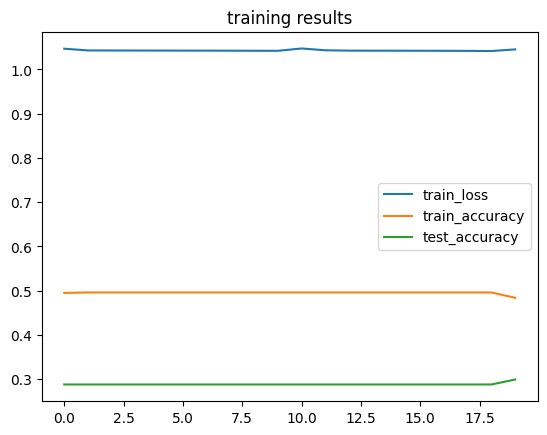

In [ ]:

#display training results for each model

for model_name, result in results.items():
    plt.plot(result.history['accuracy'], label='Training')
    plt.plot(result.history['val_accuracy'], label='Testing')
    plt.title(model_name)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [ ]:
#confusion matrix for all models, plot all matrices in one single plot

from sklearn.metrics import confusion_matrix
import seaborn as sns

for model_name, result in results.items():
    y_pred = model.predict(tiny_test_dataset)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.concatenate([y for x, y in tiny_test_dataset], axis=0)
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues)
    plt.title(model_name)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    


159/159 [==============================] - 1s 5ms/step


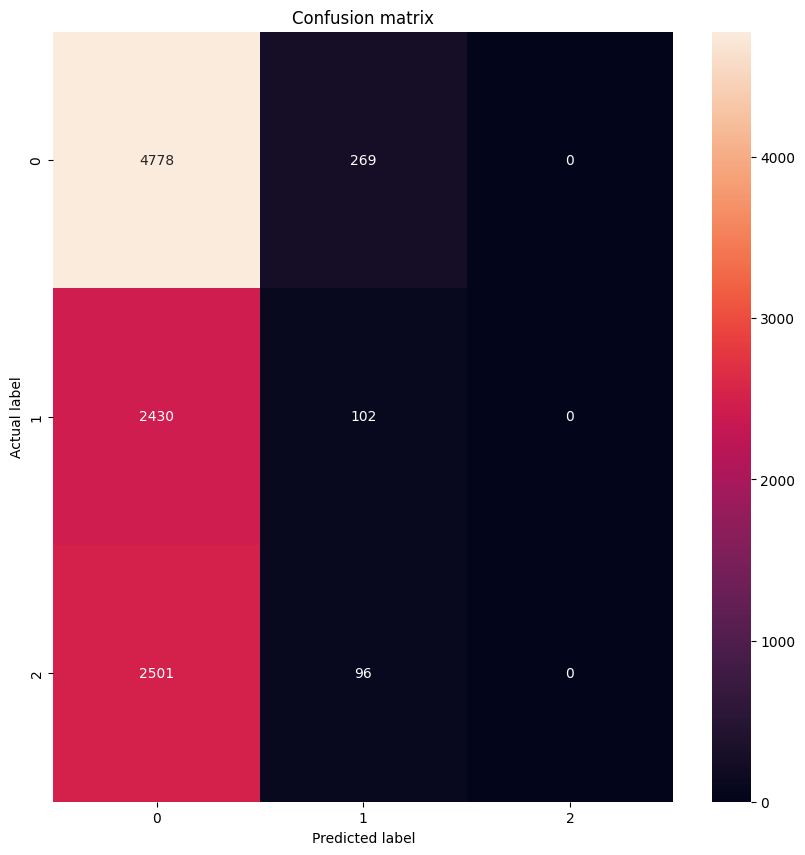

: 

FINE TUNING